# Smoothed Disperser Attenuation study for HD111980


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [537]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [538]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [539]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [540]:
from scipy import interpolate

In [541]:
import seaborn as sns

In [542]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [543]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [544]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [545]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [546]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [547]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [548]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [549]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [550]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [551]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [552]:
home=os.getenv('HOME')

In [553]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [554]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [555]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [556]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [557]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [558]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [559]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [560]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [561]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [562]:
date="20170608"

In [563]:
idx_sel_subdir=9

In [564]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [565]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [566]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [567]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [568]:
wlshift.head()

index  wlshift
0      4      0.0
1      5      2.0
2      7      2.0
3      8      1.0
4      9      5.0

### path for spectra

In [569]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [570]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [571]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [572]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [573]:
sel_obs.head()

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-06-09T00:23:03.951      4  784  5,6   0   1,021  0,962       60   
2017-06-09T00:24:57.006      5  784  5,6   0   1,021  0,962       60   
2017-06-09T00:26:53.450      6  784  5,5   0   1,021  0,962       60   
2017-06-09T00:28:47.905      7  784  5,5   0   1,021  0,962       60   
2017-06-09T00:30:44.403      8  784  5,5   0   1,021  0,962       60   

                           object filter disperser  focus     W        subdir  \
date                                                                            
2017-06-09T00:23:03.951  HD111980  FGB37    Ron200  12450  15,2  data_08jun17   
2017-06-09T00:24:57.006  HD111980  RG715    Ron200  12450  14,5  data_08jun17   
2017-06-09T00:26:53.450  HD111980  FGB37   Thor300  12450  14,2  data_08jun17   
2017-06-09T00:28:47.905  HD111980  RG715   Thor300  12450    13  data_08jun17   
2017-06-09T00:30:44.403  HD111980  FGB37   HoloPhP  12450  14,7  data_08jun17   

                                            file  
date                                              
2017-06-09T00:23:03.951  reduc_20170608_004.fits  
2017-06-09T00:24:57.006  reduc_20170608_005.fits  
2017-06-09T00:26:53.450  reduc_20170608_006.fits  
2017-06-09T00:28:47.905  reduc_20170608_007.fits  
2017-06-09T00:30:44.403  reduc_20170608_008.fits

In [574]:
sel_obs.tail()

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-06-09T10:32:32.106    353  783  8,6  31   1,051  0,962       30   
2017-06-09T10:33:58.007    354  783  8,6  35   1,053  0,962       15   
2017-06-09T10:35:07.405    355  783  8,6   0   1,055  0,962       15   
2017-06-09T10:36:16.849    356  783  8,7   0   1,056  0,962       15   
2017-06-09T10:37:26.304    357  783  8,6   0   1,058  0,962       15   

                           object filter disperser  focus     W        subdir  \
date                                                                            
2017-06-09T10:32:32.106  HD205905  RG715  HoloAmAg  12450   9,6  data_08jun17   
2017-06-09T10:33:58.007  HD205905  FGB37    Ron200  12450     7  data_08jun17   
2017-06-09T10:35:07.405  HD205905  RG715    Ron200  12450   6,5  data_08jun17   
2017-06-09T10:36:16.849  HD205905  FGB37   Thor300  12450  13,4  data_08jun17   
2017-06-09T10:37:26.304  HD205905  RG715   Thor300  12450   7,6  data_08jun17   

                                            file  
date                                              
2017-06-09T10:32:32.106  reduc_20170608_353.fits  
2017-06-09T10:33:58.007  reduc_20170608_354.fits  
2017-06-09T10:35:07.405  reduc_20170608_355.fits  
2017-06-09T10:36:16.849  reduc_20170608_356.fits  
2017-06-09T10:37:26.304  reduc_20170608_357.fits

### Quick view on the kind of sources

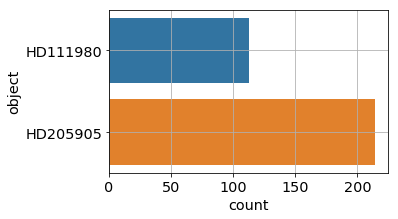

In [575]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

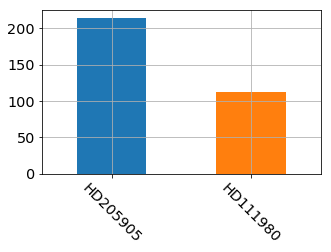

In [576]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad sources

- remove star **PNG336.3-05.6**

In [577]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD205905'])]
bad_indexes=bad_obs["index"]

In [578]:
bad_obs

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-06-09T06:08:41.754    144  784  7,6   0   1,305  0,962       15   
2017-06-09T06:09:51.160    145  784  7,7  32     1,3  0,962       15   
2017-06-09T06:11:00.505    146  784  7,7  32   1,295  0,962       15   
2017-06-09T06:12:09.894    147  784  7,7  41   1,291  0,962       15   
2017-06-09T06:13:19.305    148  784  7,7  33   1,286  0,962       15   
2017-06-09T06:14:28.702    149  784  7,7  32   1,282  0,962       15   
2017-06-09T06:15:38.302    150  784  7,6  32   1,277  0,962       30   
2017-06-09T06:17:02.700    151  784  7,7  32   1,272  0,962       30   
2017-06-09T06:18:29.147    152  784  7,7  32   1,267  0,962       30   
2017-06-09T06:19:53.498    153  784  7,7  32   1,261  0,962       30   
2017-06-09T06:21:18.801    154  784  7,7  37   1,256  0,962       15   
2017-06-09T06:22:28.198    155  784  7,6  32   1,252  0,962       15   
2017-06-09T06:23:37.401    156  784  7,6  32   1,248  0,962       15   
2017-06-09T06:24:46.801    157  784  7,7  32   1,244  0,962       15   
2017-06-09T06:25:56.200    158  784  7,7  32    1,24  0,962       15   
2017-06-09T06:27:05.648    159  784  7,7  43   1,236  0,962       15   
2017-06-09T06:28:15.158    160  784  7,7  38   1,232  0,962       30   
2017-06-09T06:29:39.401    161  784  7,6  33   1,228  0,962       30   
2017-06-09T06:31:05.855    162  784  7,7  32   1,223  0,962       30   
2017-06-09T06:32:30.102    163  784  7,7   0   1,218  0,962       30   
2017-06-09T06:33:54.701    164  784  7,7  32   1,214  0,962       15   
2017-06-09T06:35:02.806    165  784  7,7  32    1,21  0,962       15   
2017-06-09T06:36:14.244    166  784  7,6  32   1,207  0,962       15   
2017-06-09T06:37:23.602    167  783  7,6  32   1,203  0,962       15   
2017-06-09T06:38:33.043    168  784  7,5  37     1,2  0,962       15   
2017-06-09T06:39:42.405    169  784  7,5  32   1,196  0,962       15   
2017-06-09T06:40:51.997    170  784  7,5  32   1,193  0,962       30   
2017-06-09T06:42:16.402    171  784  7,5  32   1,189  0,962       30   
2017-06-09T06:43:40.798    172  784  7,5  34   1,185  0,962       30   
2017-06-09T06:45:05.197    173  784  7,5  32   1,181  0,962       30   
...                        ...  ...  ...  ..     ...    ...      ...   
2017-06-09T10:00:42.795    328  783  8,8  25   1,019  0,962       15   
2017-06-09T10:01:52.202    329  783  8,6  25    1,02  0,962       15   
2017-06-09T10:03:01.749    330  783  8,6  25   1,021  0,962       30   
2017-06-09T10:04:26.097    331  783  8,6  25   1,022  0,962       30   
2017-06-09T10:05:52.352    332  783  8,7  25   1,023  0,962       30   
2017-06-09T10:07:16.753    333  783  8,7  25   1,024  0,962       30   
2017-06-09T10:08:42.602    334  783  8,7  25   1,026  0,962       15   
2017-06-09T10:09:51.803    335  783  8,8  25   1,027  0,962       15   
2017-06-09T10:11:01.202    336  783  8,7  25   1,028  0,962       15   
2017-06-09T10:12:10.594    337  783  8,7  25   1,029  0,962       15   
2017-06-09T10:13:22.053    338  783  8,7  25    1,03  0,962       15   
2017-06-09T10:14:31.398    339  783  8,7  25   1,031  0,962       15   
2017-06-09T10:15:41.000    340  783  8,7  25   1,032  0,962       30   
2017-06-09T10:17:05.446    341  783  8,6  25   1,034  0,962       30   
2017-06-09T10:18:31.949    342  783  8,7  26   1,035  0,962       30   
2017-06-09T10:19:56.395    343  783  8,6  26   1,037  0,962       30   
2017-06-09T10:21:21.701    344  783  8,6  26   1,038  0,962       15   
2017-06-09T10:22:31.098    345  783  8,6  27   1,039  0,962       15   
2017-06-09T10:23:40.500    346  783  8,6  29   1,041  0,962       15   
2017-06-09T10:24:49.901    347  783  8,5  30   1,042  0,962       15   
2017-06-09T10:25:59.349    348  783  8,6  30   1,043  0,962       15   
2017-06-09T10:27:08.803    349  783  8,6  30   1,045  0,962       15   
2017-06-09T10:28:19.201    350  783  8,6   0   1,046  0,962      

In [579]:
bad_indexes=bad_obs.loc[:,"index"]

In [580]:
bad_indexes.index

Index([u'2017-06-09T06:08:41.754', u'2017-06-09T06:09:51.160',
       u'2017-06-09T06:11:00.505', u'2017-06-09T06:12:09.894',
       u'2017-06-09T06:13:19.305', u'2017-06-09T06:14:28.702',
       u'2017-06-09T06:15:38.302', u'2017-06-09T06:17:02.700',
       u'2017-06-09T06:18:29.147', u'2017-06-09T06:19:53.498',
       ...
       u'2017-06-09T10:25:59.349', u'2017-06-09T10:27:08.803',
       u'2017-06-09T10:28:19.201', u'2017-06-09T10:29:43.598',
       u'2017-06-09T10:31:07.802', u'2017-06-09T10:32:32.106',
       u'2017-06-09T10:33:58.007', u'2017-06-09T10:35:07.405',
       u'2017-06-09T10:36:16.849', u'2017-06-09T10:37:26.304'],
      dtype='object', name=u'date', length=214)

In [581]:
bad_indexes.values

array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 32

### Concatenate bad obs

In [582]:
#bad_obs=pd.concat([bad_obs,bad_obs_0])

In [583]:
#bad_obs

In [584]:
bad_obs.sort_values(by="index",inplace=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [585]:
bad_indexes=bad_obs.loc[:,"index"]

In [586]:
bad_indexes.index

Index([u'2017-06-09T06:08:41.754', u'2017-06-09T06:09:51.160',
       u'2017-06-09T06:11:00.505', u'2017-06-09T06:12:09.894',
       u'2017-06-09T06:13:19.305', u'2017-06-09T06:14:28.702',
       u'2017-06-09T06:15:38.302', u'2017-06-09T06:17:02.700',
       u'2017-06-09T06:18:29.147', u'2017-06-09T06:19:53.498',
       ...
       u'2017-06-09T10:25:59.349', u'2017-06-09T10:27:08.803',
       u'2017-06-09T10:28:19.201', u'2017-06-09T10:29:43.598',
       u'2017-06-09T10:31:07.802', u'2017-06-09T10:32:32.106',
       u'2017-06-09T10:33:58.007', u'2017-06-09T10:35:07.405',
       u'2017-06-09T10:36:16.849', u'2017-06-09T10:37:26.304'],
      dtype='object', name=u'date', length=214)

In [587]:
bad_indexes.values

array([144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 32

- keep stars **HD111980**, **HD205905**

In [588]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980'])]

In [589]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

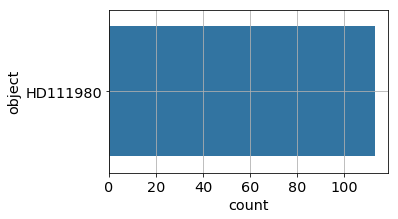

In [590]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [591]:
list_of_objects=sel2_obs['object'].values

In [592]:
list_of_objects=set(list_of_objects)

In [593]:
list_of_objects=list(list_of_objects)

In [594]:
list_of_objects_str=','.join(list_of_objects)

# Remove bad indexes


In [595]:
bad_calib_indexes=np.array([6,16,23,26,36,46,56,66,76,86,96,106,116])

In [596]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_calib_indexes:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f) 

 remove  reduc_20170608_006_spectrum.fits
 remove  reduc_20170608_016_spectrum.fits
 remove  reduc_20170608_023_spectrum.fits
 remove  reduc_20170608_026_spectrum.fits
 remove  reduc_20170608_036_spectrum.fits
 remove  reduc_20170608_046_spectrum.fits
 remove  reduc_20170608_056_spectrum.fits
 remove  reduc_20170608_066_spectrum.fits
 remove  reduc_20170608_076_spectrum.fits
 remove  reduc_20170608_086_spectrum.fits
 remove  reduc_20170608_096_spectrum.fits
 remove  reduc_20170608_106_spectrum.fits
 remove  reduc_20170608_116_spectrum.fits


### find filename for sim spectra

In [597]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [598]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [599]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/clearsky/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/clearsky/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/clearsky/specsim_20170608_006_spectrum.fits']

In [600]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [601]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/standard/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/standard/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/standard/specsim_20170608_006_spectrum.fits']

In [602]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [603]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/merra2/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/merra2/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_08jun17/merra2/specsim_20170608_006_spectrum.fits']

# Remove bad indexes

In [604]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170608_144_spectrum.fits
 remove  reduc_20170608_145_spectrum.fits
 remove  reduc_20170608_146_spectrum.fits
 remove  reduc_20170608_147_spectrum.fits
 remove  reduc_20170608_148_spectrum.fits
 remove  reduc_20170608_149_spectrum.fits
 remove  reduc_20170608_150_spectrum.fits
 remove  reduc_20170608_151_spectrum.fits
 remove  reduc_20170608_152_spectrum.fits
 remove  reduc_20170608_153_spectrum.fits
 remove  reduc_20170608_154_spectrum.fits
 remove  reduc_20170608_155_spectrum.fits
 remove  reduc_20170608_156_spectrum.fits
 remove  reduc_20170608_157_spectrum.fits
 remove  reduc_20170608_158_spectrum.fits
 remove  reduc_20170608_159_spectrum.fits
 remove  reduc_20170608_160_spectrum.fits
 remove  reduc_20170608_161_spectrum.fits
 remove  reduc_20170608_162_spectrum.fits
 remove  reduc_20170608_163_spectrum.fits
 remove  reduc_20170608_164_spectrum.fits
 remove  reduc_20170608_165_spectrum.fits
 remove  reduc_20170608_166_spectrum.fits
 remove  reduc_20170608_167_spectr

In [605]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170608_144_spectrum.fits
 remove  specsim_20170608_145_spectrum.fits
 remove  specsim_20170608_146_spectrum.fits
 remove  specsim_20170608_147_spectrum.fits
 remove  specsim_20170608_148_spectrum.fits
 remove  specsim_20170608_149_spectrum.fits
 remove  specsim_20170608_150_spectrum.fits
 remove  specsim_20170608_151_spectrum.fits
 remove  specsim_20170608_152_spectrum.fits
 remove  specsim_20170608_153_spectrum.fits
 remove  specsim_20170608_154_spectrum.fits
 remove  specsim_20170608_155_spectrum.fits
 remove  specsim_20170608_156_spectrum.fits
 remove  specsim_20170608_157_spectrum.fits
 remove  specsim_20170608_158_spectrum.fits
 remove  specsim_20170608_159_spectrum.fits
 remove  specsim_20170608_160_spectrum.fits
 remove  specsim_20170608_161_spectrum.fits
 remove  specsim_20170608_162_spectrum.fits
 remove  specsim_20170608_163_spectrum.fits
 remove  specsim_20170608_164_spectrum.fits
 remove  specsim_20170608_165_spectrum.fits
 remove  specsim_20170608_166_sp

In [606]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170608_144_spectrum.fits
 remove  specsim_20170608_145_spectrum.fits
 remove  specsim_20170608_146_spectrum.fits
 remove  specsim_20170608_147_spectrum.fits
 remove  specsim_20170608_148_spectrum.fits
 remove  specsim_20170608_149_spectrum.fits
 remove  specsim_20170608_150_spectrum.fits
 remove  specsim_20170608_151_spectrum.fits
 remove  specsim_20170608_152_spectrum.fits
 remove  specsim_20170608_153_spectrum.fits
 remove  specsim_20170608_154_spectrum.fits
 remove  specsim_20170608_155_spectrum.fits
 remove  specsim_20170608_156_spectrum.fits
 remove  specsim_20170608_157_spectrum.fits
 remove  specsim_20170608_158_spectrum.fits
 remove  specsim_20170608_159_spectrum.fits
 remove  specsim_20170608_160_spectrum.fits
 remove  specsim_20170608_161_spectrum.fits
 remove  specsim_20170608_162_spectrum.fits
 remove  specsim_20170608_163_spectrum.fits
 remove  specsim_20170608_164_spectrum.fits
 remove  specsim_20170608_165_spectrum.fits
 remove  specsim_20170608_166_sp

In [607]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170608_144_spectrum.fits
 remove  specsim_20170608_145_spectrum.fits
 remove  specsim_20170608_146_spectrum.fits
 remove  specsim_20170608_147_spectrum.fits
 remove  specsim_20170608_148_spectrum.fits
 remove  specsim_20170608_149_spectrum.fits
 remove  specsim_20170608_150_spectrum.fits
 remove  specsim_20170608_151_spectrum.fits
 remove  specsim_20170608_152_spectrum.fits
 remove  specsim_20170608_153_spectrum.fits
 remove  specsim_20170608_154_spectrum.fits
 remove  specsim_20170608_155_spectrum.fits
 remove  specsim_20170608_156_spectrum.fits
 remove  specsim_20170608_157_spectrum.fits
 remove  specsim_20170608_158_spectrum.fits
 remove  specsim_20170608_159_spectrum.fits
 remove  specsim_20170608_160_spectrum.fits
 remove  specsim_20170608_161_spectrum.fits
 remove  specsim_20170608_162_spectrum.fits
 remove  specsim_20170608_163_spectrum.fits
 remove  specsim_20170608_164_spectrum.fits
 remove  specsim_20170608_165_spectrum.fits
 remove  specsim_20170608_166_sp

# which filters

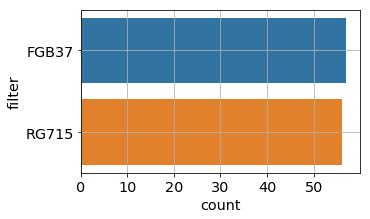

In [608]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

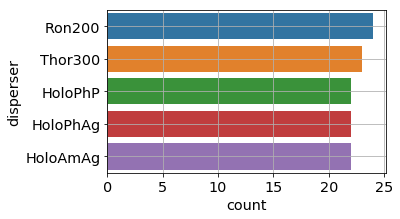

In [609]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

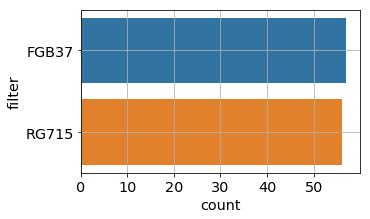

In [610]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

In [611]:
sel_obs_Ron200=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron200'])]

In [612]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [613]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [614]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [615]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## Show the reconstructed spectra

In [616]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170608_([0-9]+)_spectrum.fits$


### Ronchi 200 spectra

In [617]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200"

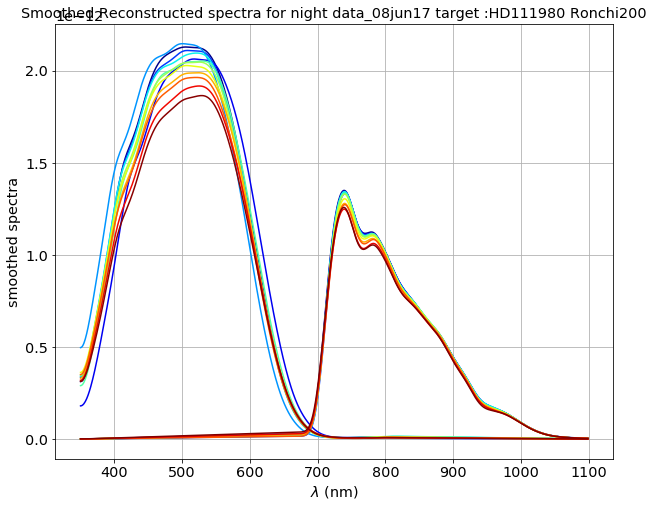

In [618]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron200,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### Thor 300

In [619]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

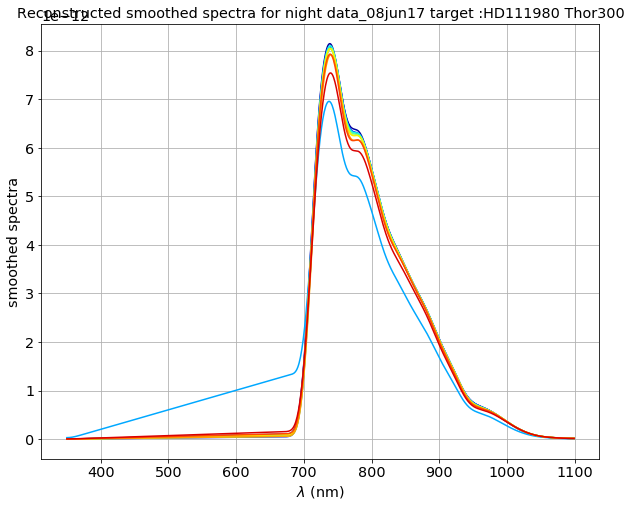

In [620]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhP

In [621]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

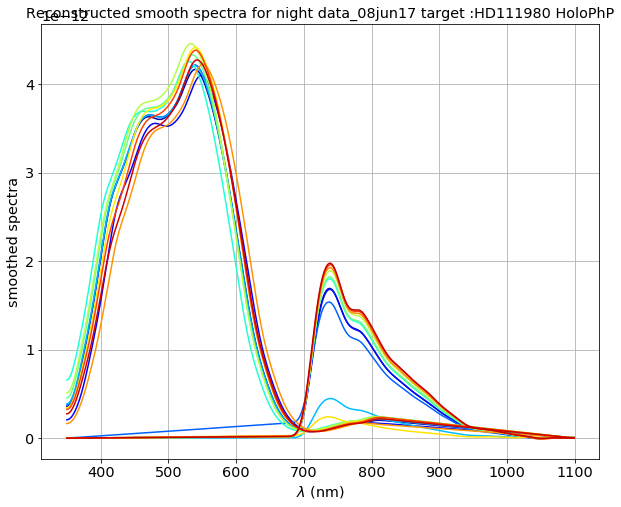

In [622]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhAg

In [623]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

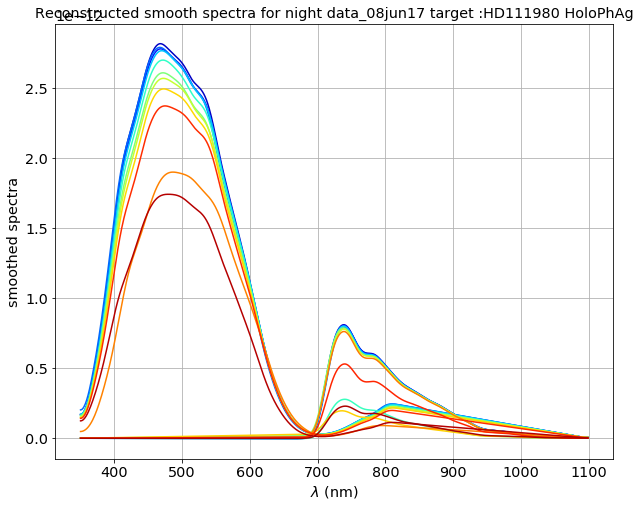

In [624]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloAmAg

In [625]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

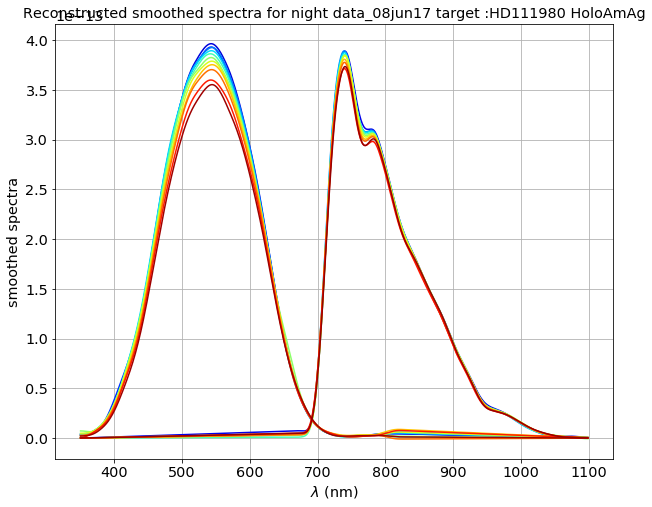

In [626]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

## Show the simulated spectra

In [627]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [628]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

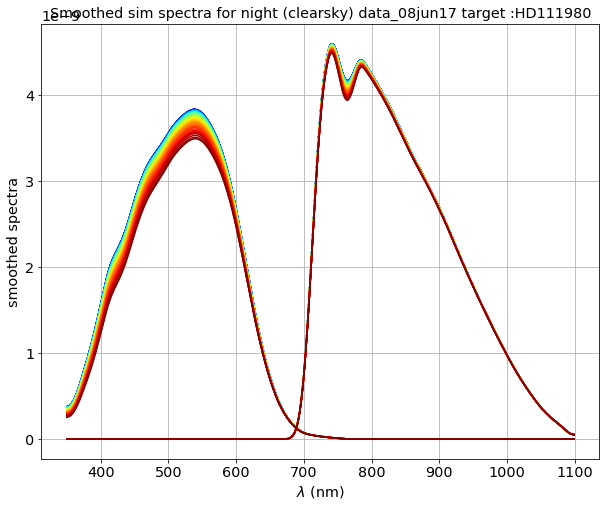

In [629]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### standard sky

In [630]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

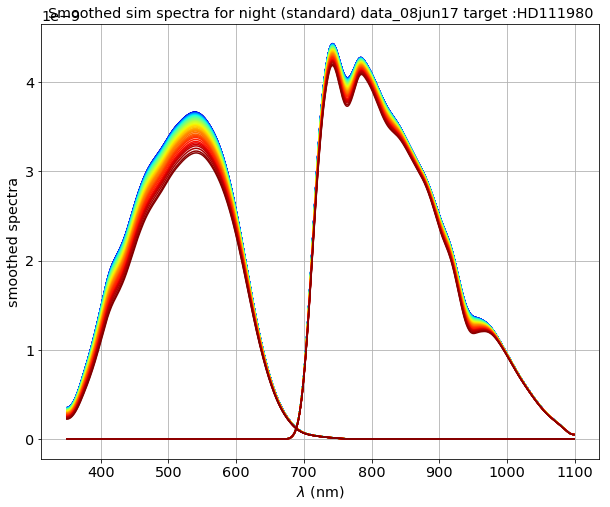

In [631]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### merra2 sky

In [632]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

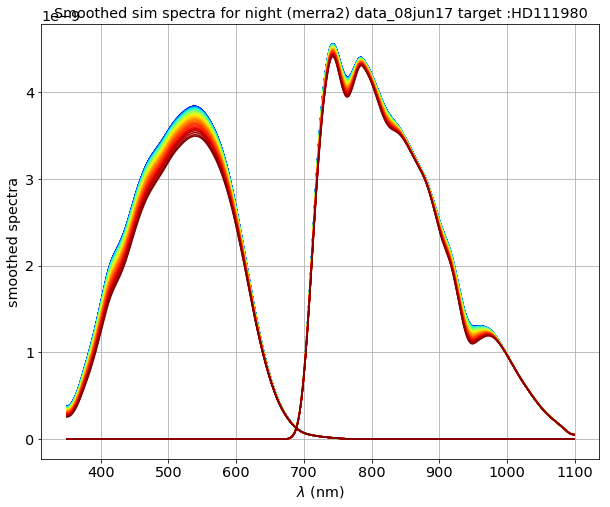

In [633]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

# Airmass vs image index

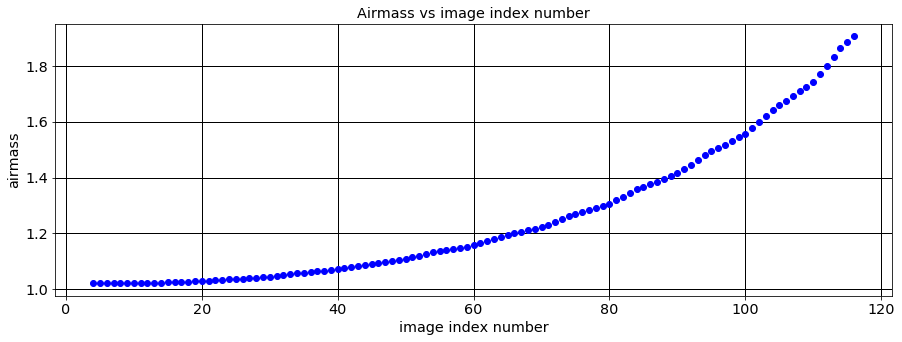

In [634]:
PlotAirmass(sel2_obs)

# Attenuation

## Data

In [635]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Ronchi 200

In [636]:
sel_obs_Ron200_Red=sel_obs_Ron200[sel_obs_Ron200["filter"]=='RG715']
sel_obs_Ron200_Blue=sel_obs_Ron200[sel_obs_Ron200["filter"]=='FGB37']

#### Blue

In [637]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

In [638]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200 + Blue Filter"

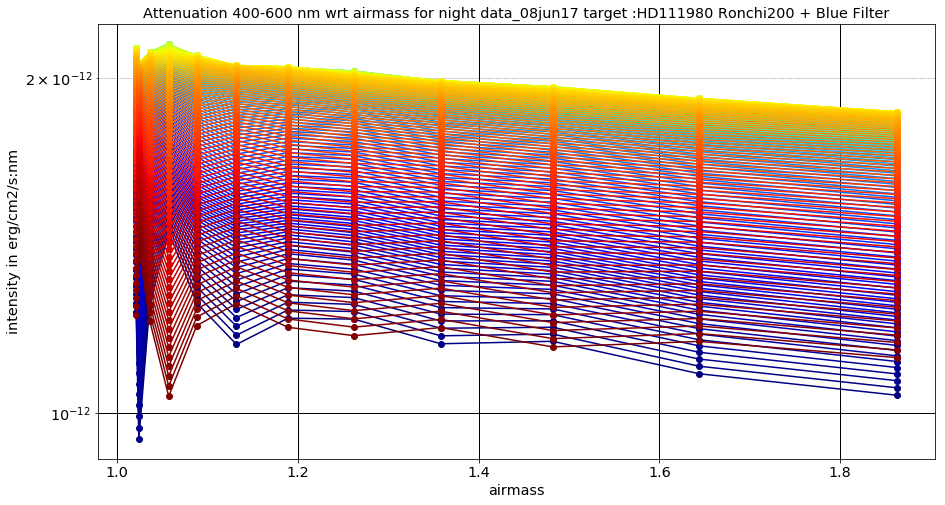

In [639]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_Ron200_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [640]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200 + Blue Filter"

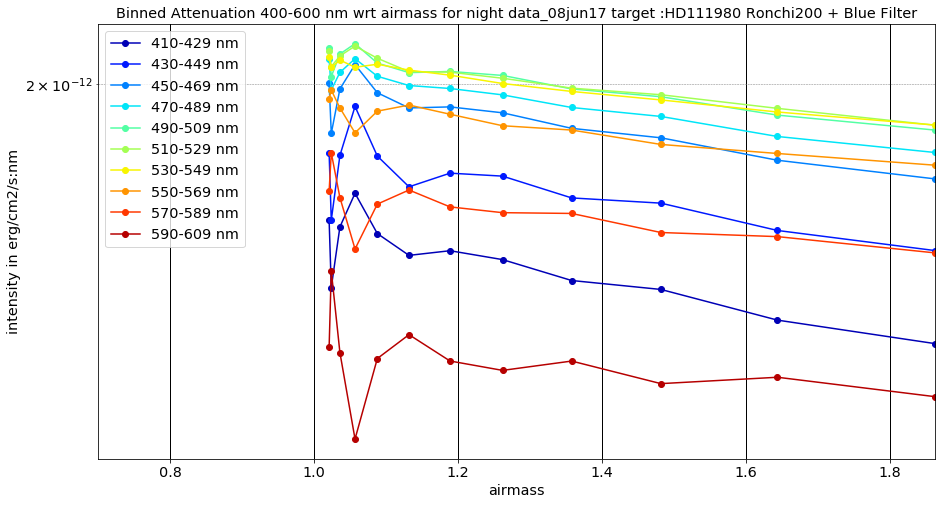

In [641]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron200_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [642]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200 + Red Filter"

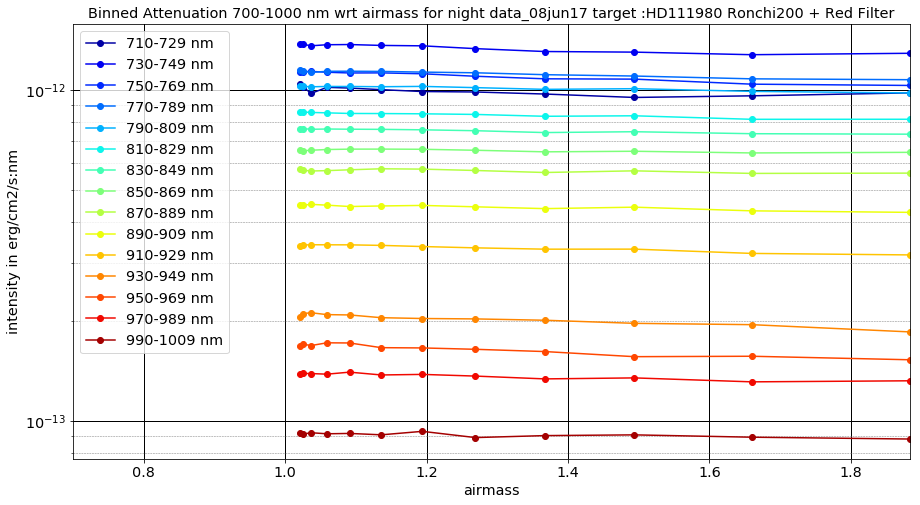

In [643]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron200_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 

### Thor300

In [644]:
sel_obs_Thor300_Red=sel_obs_Thor300[sel_obs_Thor300["filter"]=='RG715']
sel_obs_Thor300_Blue=sel_obs_Thor300[sel_obs_Thor300["filter"]=='FGB37']

In [645]:
thetitle="Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300 + Red Filter"

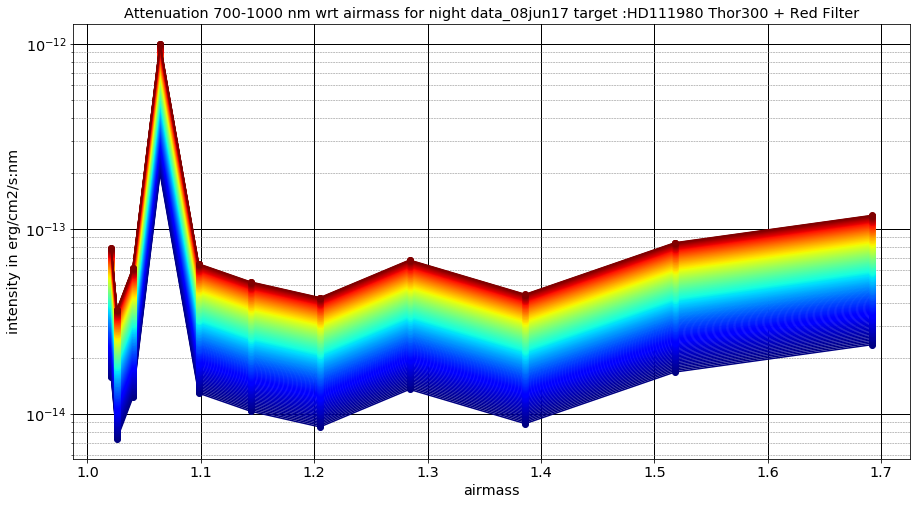

In [646]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_Thor300_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

#### Blue filter

These data have not been reconstructed probably due to saturation of Thor300

In [647]:
#thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300 + Blue"

In [648]:
#PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Thor300_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

#### Red filter

In [649]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300 + Red Filter"

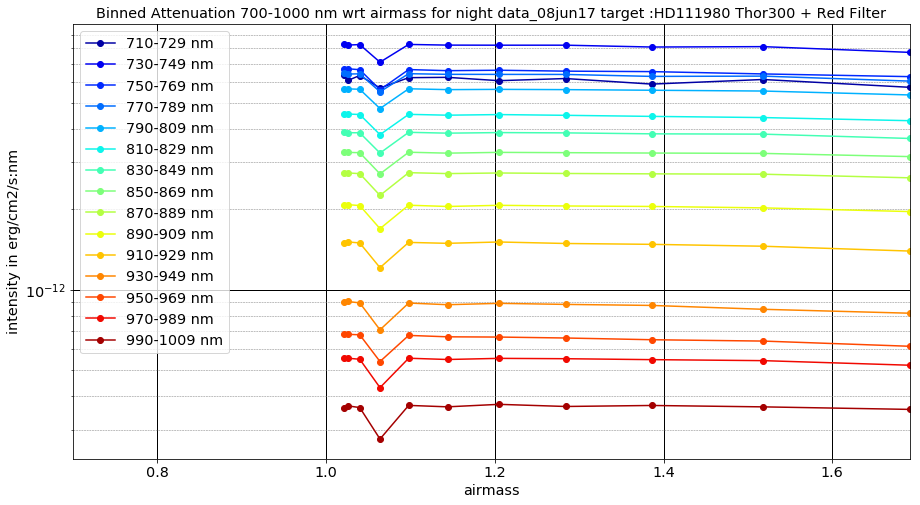

In [650]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Thor300_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

### HoloPhP

In [651]:
sel_obs_HoloPhP_Red=sel_obs_HoloPhP[sel_obs_HoloPhP["filter"]=='RG715']
sel_obs_HoloPhP_Blue=sel_obs_HoloPhP[sel_obs_HoloPhP["filter"]=='FGB37']

In [652]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP + Blue Filter"

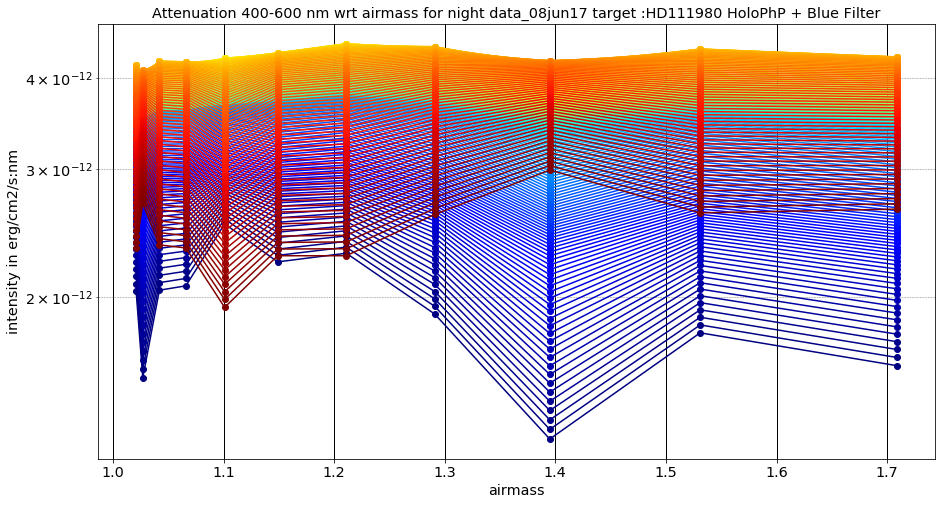

In [653]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloPhP_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

#### Blue filter

In [654]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP + Blue Filter"

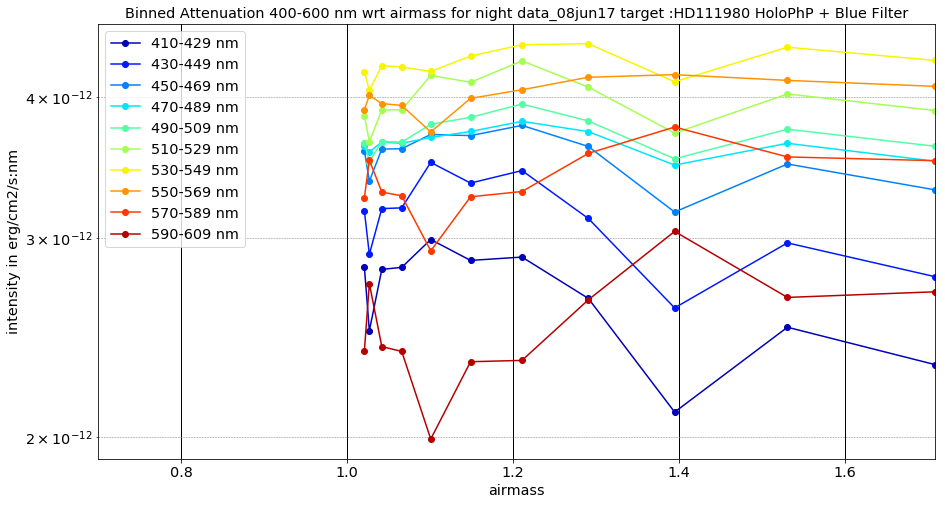

In [655]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhP_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

#### Red Filter

In [656]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP + Red Filter"

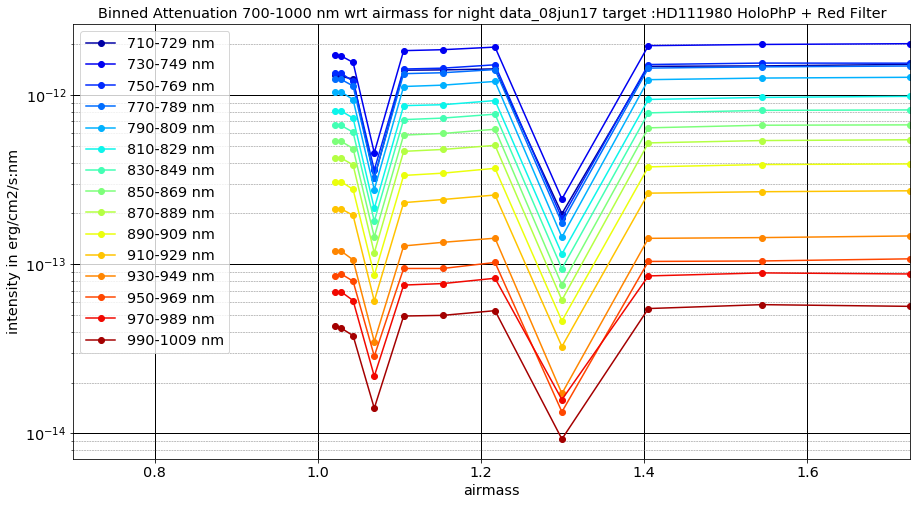

In [657]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhP_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

### HoloPhAg

In [658]:
sel_obs_HoloPhAg_Red=sel_obs_HoloPhAg[sel_obs_HoloPhAg["filter"]=='RG715']
sel_obs_HoloPhAg_Blue=sel_obs_HoloPhAg[sel_obs_HoloPhAg["filter"]=='FGB37']

In [659]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg + Blue Filter"

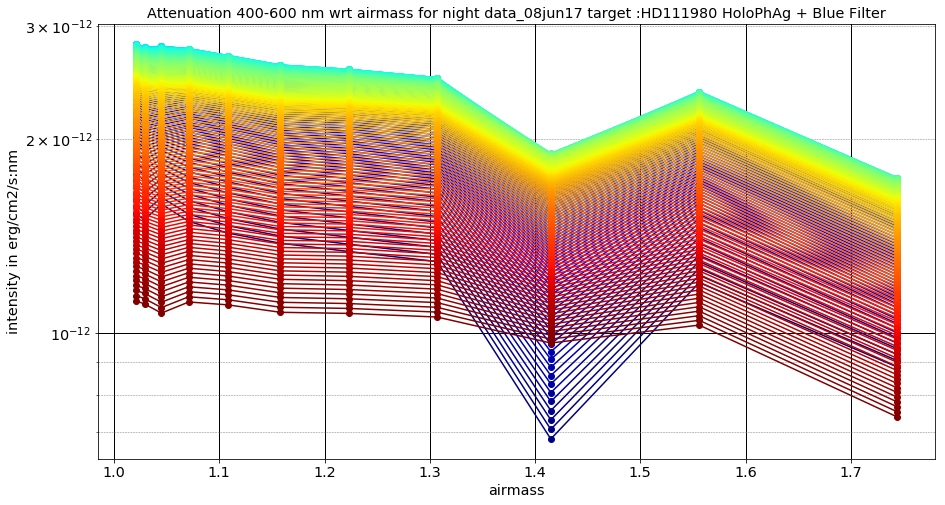

In [660]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloPhAg_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

#### Blue filter

In [661]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg + Blue Filter"

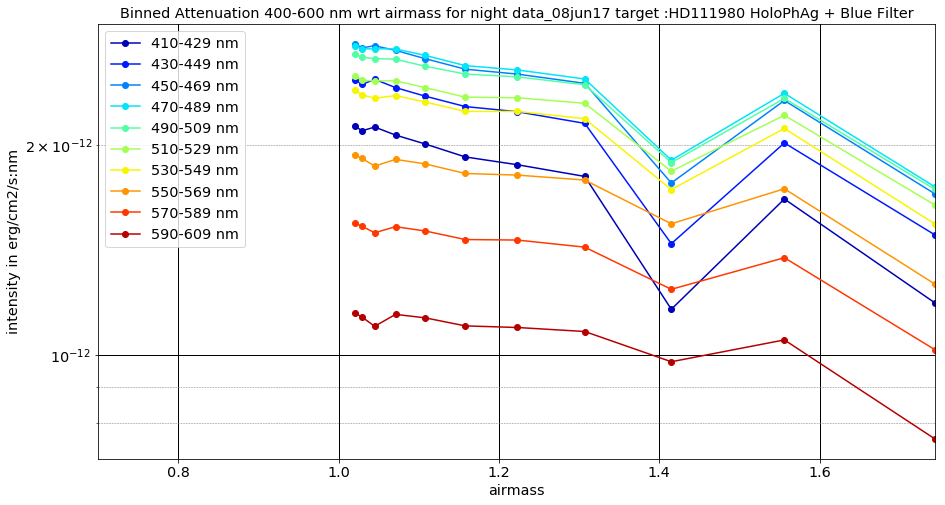

In [662]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhAg_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

#### Red Filter

In [663]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg + Red Filter"

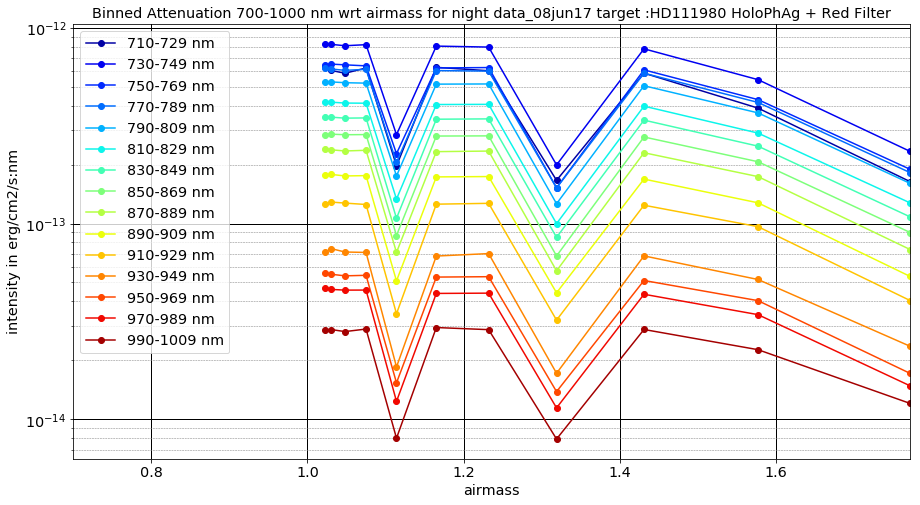

In [664]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloPhAg_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

### HoloAmAg

In [665]:
sel_obs_HoloAmAg_Red=sel_obs_HoloAmAg[sel_obs_HoloAmAg["filter"]=='RG715']
sel_obs_HoloAmAg_Blue=sel_obs_HoloAmAg[sel_obs_HoloAmAg["filter"]=='FGB37']

In [666]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg + Blue Filter"

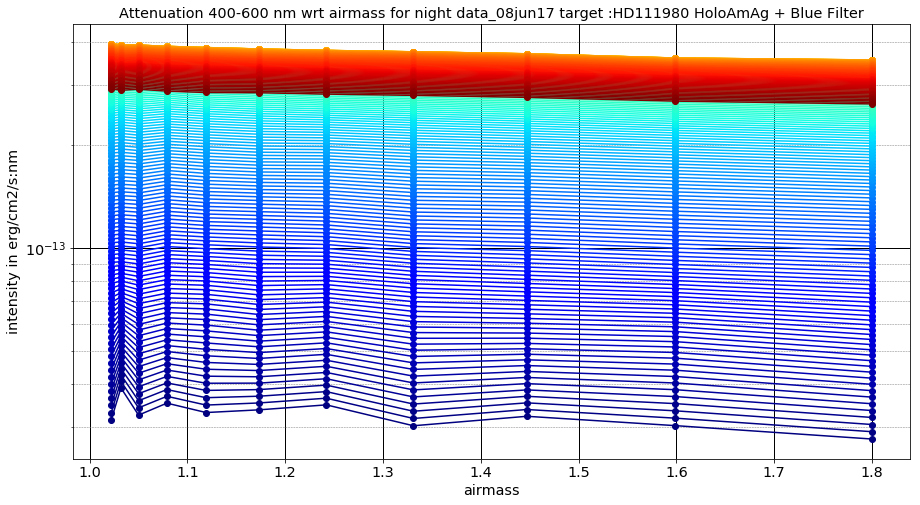

In [667]:
PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_HoloAmAg_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

#### Blue filter

In [668]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg+ Blue Filter"

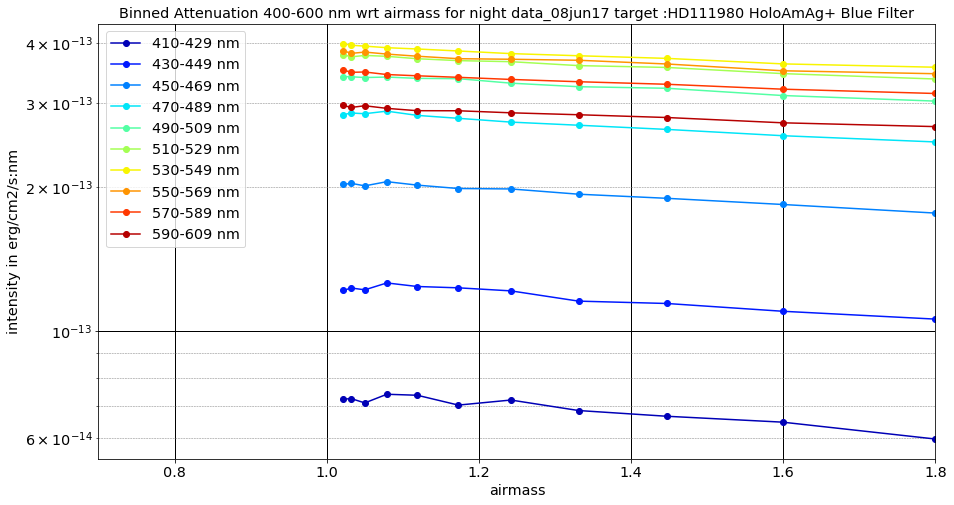

In [669]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloAmAg_Blue,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

#### Red Filter

In [670]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg + Red Filter"

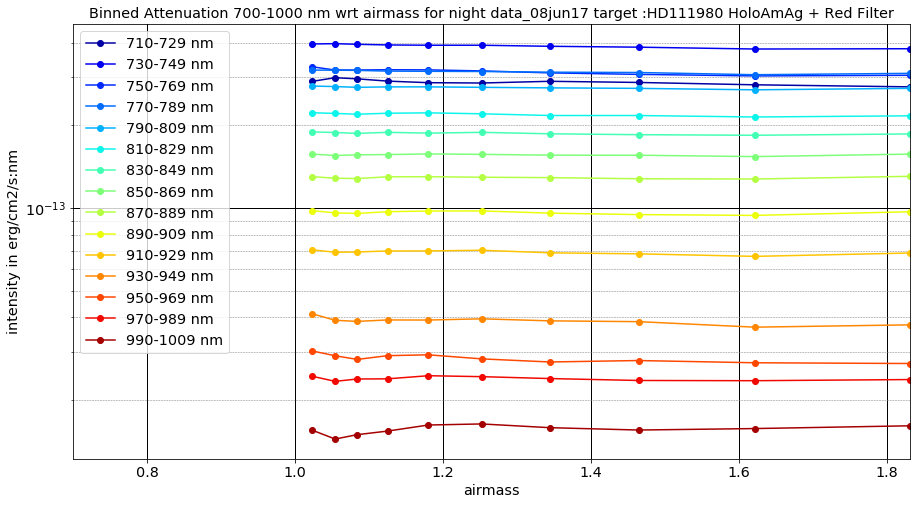

In [671]:
PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_HoloAmAg_Red,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

# Simulation

In [672]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [673]:
#SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

In [674]:
sel_obs_Red=sel2_obs[sel2_obs["filter"]=='RG715']
sel_obs_Blue=sel2_obs[sel2_obs["filter"]=='FGB37']

## Simulation with ClearSky

In [675]:
thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky + Blue Filter"

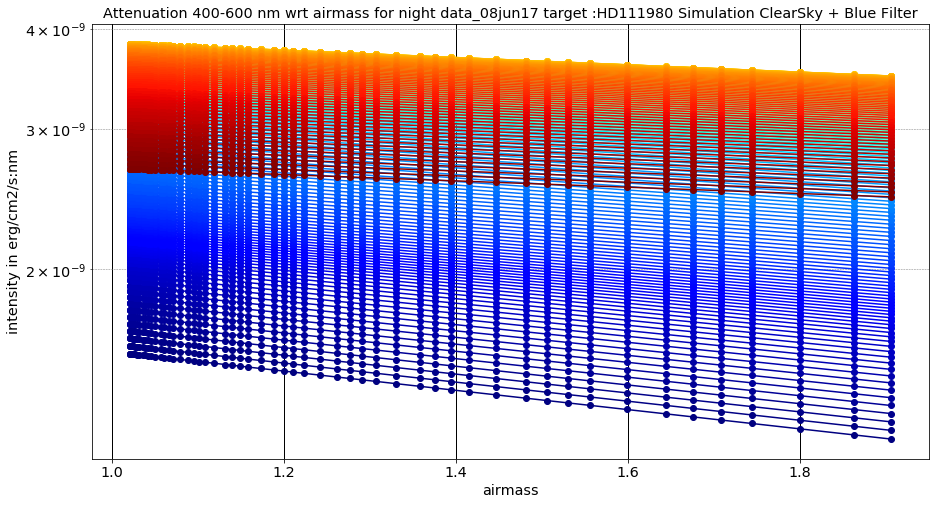

In [676]:
PlotSpectraDataSimAttenuationSmooth(all_simspectrafiles1,sel_obs_Blue,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

### Blue filter

In [677]:
thetitle="Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky + Blue Filter"

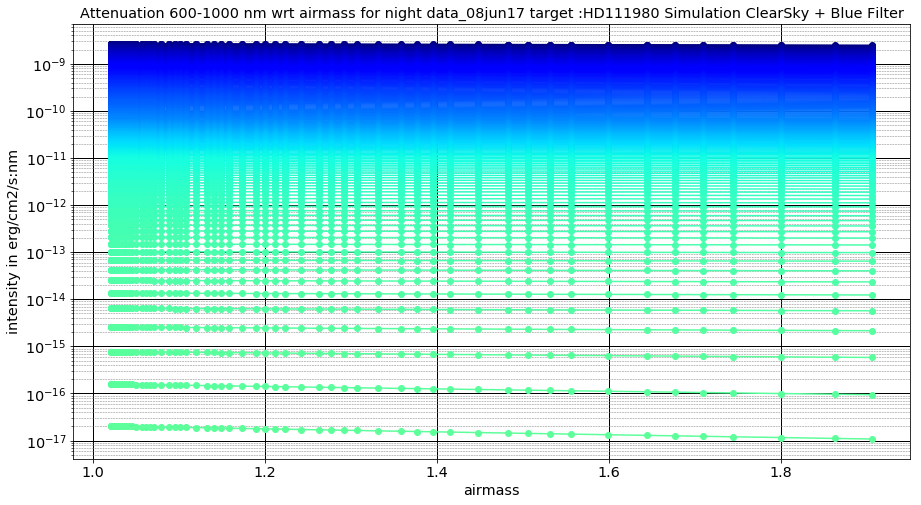

In [678]:
PlotSpectraDataSimAttenuationSmooth(all_simspectrafiles1,sel_obs_Blue,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=51)   

In [679]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky + Blue Filter"

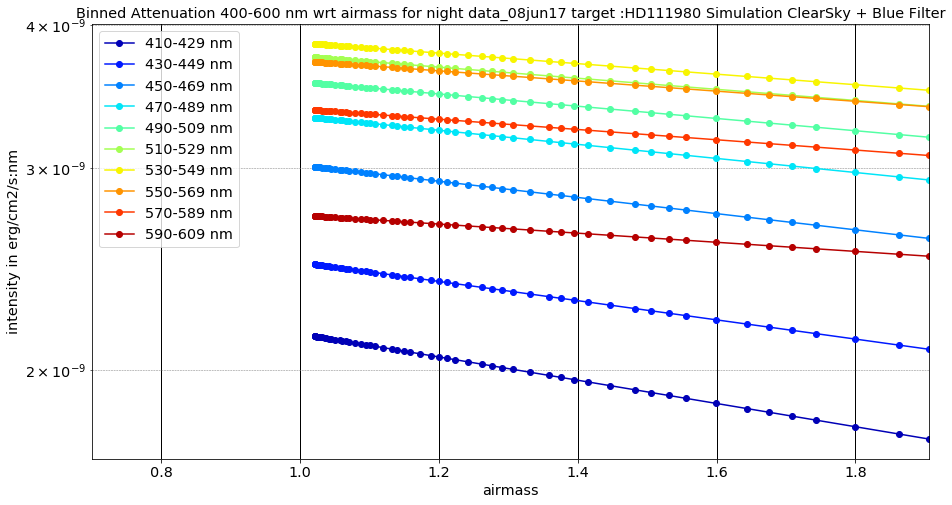

In [680]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles1,sel_obs_Blue,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

### Red filter

In [681]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky + Red Filter"

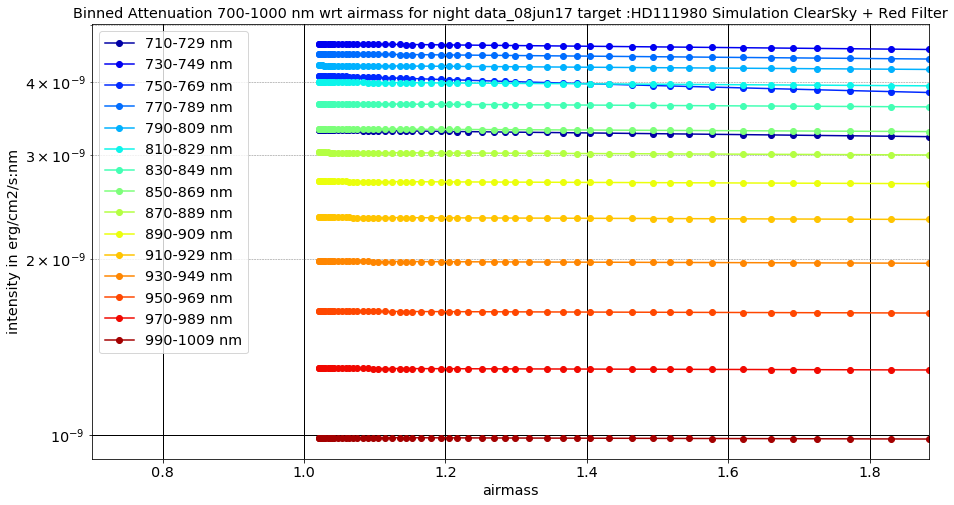

In [682]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles1,sel_obs_Red,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with average Sky

### Blue Filter

In [683]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky + Blue Filter"

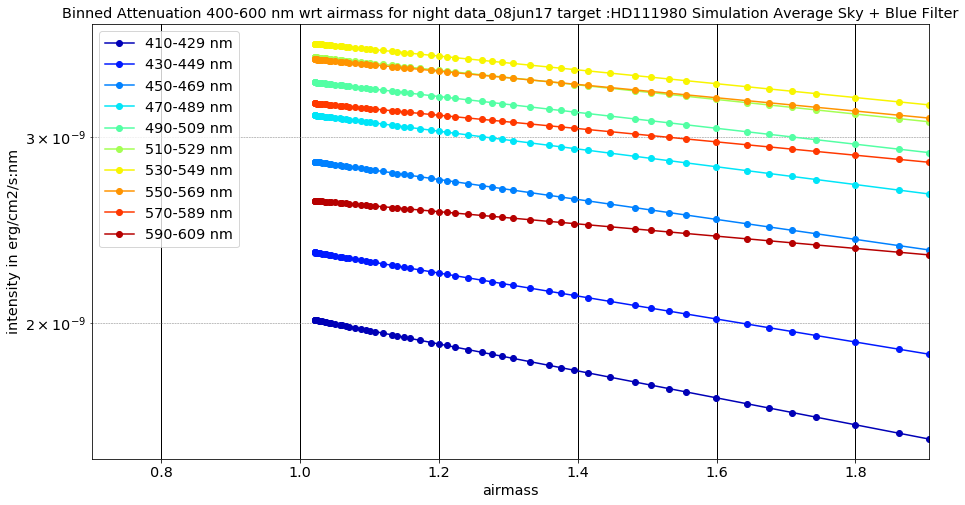

In [684]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles2,sel_obs_Blue,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

In [685]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky + Red Filter"

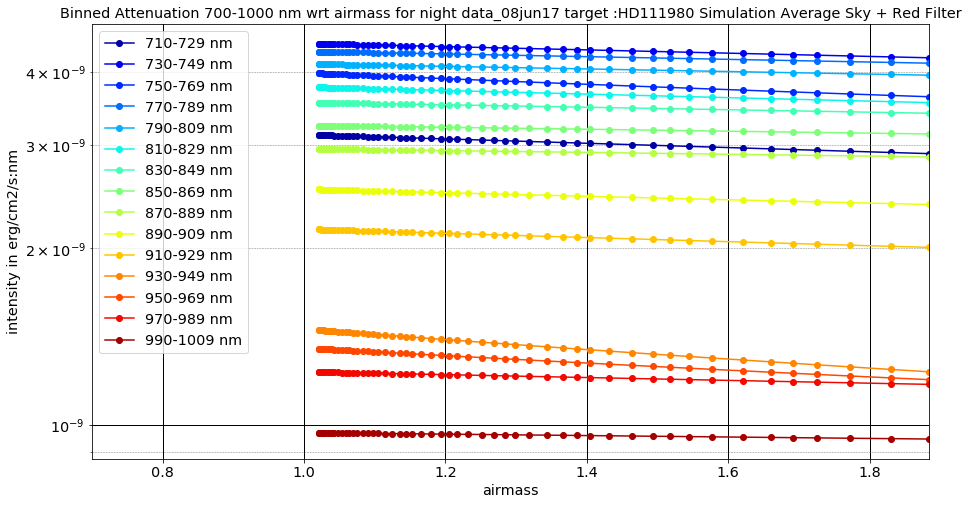

In [686]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles2,sel_obs_Red,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with MERRA2 Sky

### Blue Filter

In [687]:
thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky + Blue Filter"

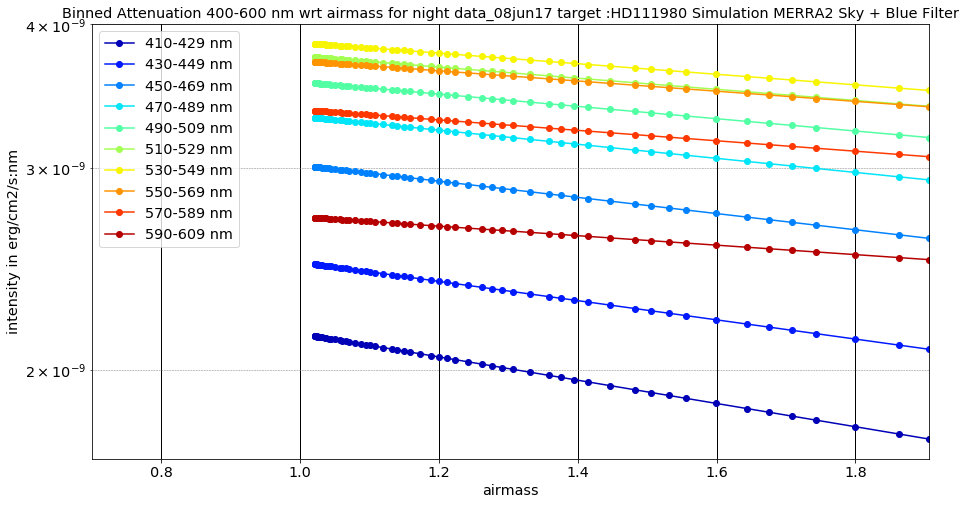

In [688]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles3,sel_obs_Blue,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

### Red Filter

In [689]:
thetitle="Binned Attenuation 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

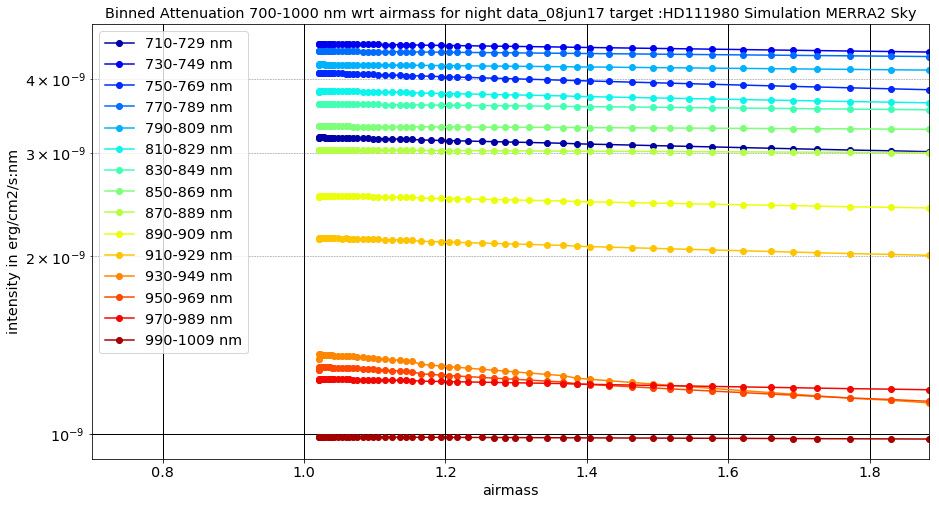

In [690]:
PlotSpectraDataSimAttenuationSmoothBin(all_simspectrafiles3,sel_obs_Red,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 